In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import numpy as np

In [55]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [56]:
# LOAD , PROCESS AND GENERATE A TF DATASET FROM DIRECTORY
plt.figure(figsize=(10,10))
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/Users/athulnambiar/Desktop/PROJECTS/POTATO DISEASE/Data',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
)

Found 2152 files belonging to 3 classes.


<Figure size 1000x1000 with 0 Axes>

In [57]:
# FOLDER NAMES
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [58]:
# LENGTH OF DATASET
# BATCH SIZE = 32 ... 68 BATCHES ... 68*32 = 2176
len(dataset)

68

(32, 256, 256, 3)
[1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 1]
tf.Tensor(
[[[159. 156. 165.]
  [157. 154. 163.]
  [156. 153. 162.]
  ...
  [180. 177. 184.]
  [135. 132. 139.]
  [166. 163. 170.]]

 [[163. 160. 169.]
  [161. 158. 167.]
  [160. 157. 166.]
  ...
  [225. 222. 229.]
  [191. 188. 195.]
  [151. 148. 155.]]

 [[166. 163. 172.]
  [165. 162. 171.]
  [163. 160. 169.]
  ...
  [153. 150. 157.]
  [181. 178. 185.]
  [146. 143. 150.]]

 ...

 [[140. 135. 139.]
  [141. 136. 140.]
  [142. 137. 141.]
  ...
  [137. 128. 131.]
  [140. 131. 134.]
  [140. 131. 134.]]

 [[141. 136. 140.]
  [140. 135. 139.]
  [139. 134. 138.]
  ...
  [125. 116. 119.]
  [126. 117. 120.]
  [128. 119. 122.]]

 [[138. 133. 137.]
  [136. 131. 135.]
  [133. 128. 132.]
  ...
  [118. 109. 112.]
  [124. 115. 118.]
  [134. 125. 128.]]], shape=(256, 256, 3), dtype=float32)
(256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[159., 156., 

2024-05-05 09:27:05.052394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


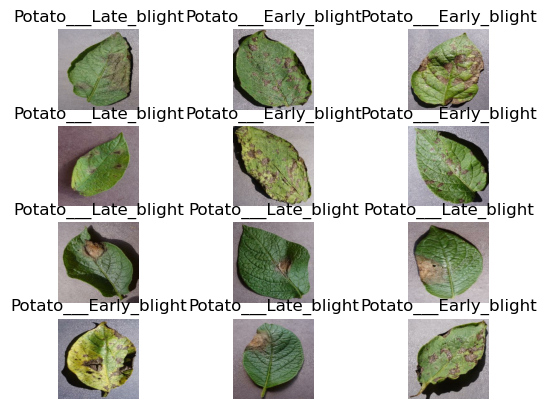

In [59]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        print(image_batch.shape)
        print(label_batch.numpy())
        print(image_batch[i])
        print(image_batch[i].shape)
        print(image_batch[i].numpy)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

### TRAINING AND VALIDATION SPLIT

80% ==> TRAINING
20% ==> 10% VALIDATION, 10% TEST

In [60]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [61]:
train_ds = dataset.take(54)
len(train_ds)

54

In [62]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [63]:
val_size = 0.1
len(dataset)*val_size


6.800000000000001

In [64]:
val_ds =dataset.take(6)
len(val_ds)

6

In [65]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [66]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)


    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds


In [67]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [68]:
len(train_ds)

54

In [69]:
len(val_ds)

6

In [70]:
len(test_ds)

8

In [71]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [72]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
])

In [73]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [74]:
preprocessed_input = tf.keras.Input(shape=(None, None, CHANNELS))  # Allow dynamic image sizes

x = tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)(preprocessed_input)
x = tf.keras.layers.Rescaling(1.0/255)(x)

# Apply data augmentation
augmented = data_augmentation(x)

# Combine preprocessing layers (optional, can be done within model)
combined_preprocess = tf.keras.Model(inputs=preprocessed_input, outputs=augmented)

### MODELM ARCHITECTURE

In [77]:
n_classes = 3

input_shape = (None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape) 

ValueError: Kernel shape must have the same length as input, but received kernel of shape (3, 3, 3, 32) and input of shape (None, None, 256, 256, 3).

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_2 (Functional)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile( 
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    batch_size =BATCH_SIZE,
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 535ms/step - accuracy: 0.4421 - loss: 4.1650 - val_accuracy: 0.5729 - val_loss: 0.8486
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 500ms/step - accuracy: 0.5739 - loss: 0.8078 - val_accuracy: 0.8281 - val_loss: 0.5112
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 625ms/step - accuracy: 0.7973 - loss: 0.4958 - val_accuracy: 0.8802 - val_loss: 0.2850
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 579ms/step - accuracy: 0.8722 - loss: 0.3290 - val_accuracy: 0.9010 - val_loss: 0.2479
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 506ms/step - accuracy: 0.9198 - loss: 0.2135 - val_accuracy: 0.9115 - val_loss: 0.1812
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 501ms/step - accuracy: 0.9099 - loss: 0.2052 - val_accuracy: 0.9844 - val_loss: 0.0735
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 494ms/step - accuracy: 0.9020 - loss: 0.2747 - val_accuracy: 0.9583 - val_loss: 0.1685
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 529ms/step - accuracy: 0.9007 - loss: 0.2369 - val_accu

In [ ]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9123 - loss: 0.2607


In [ ]:
scores

[0.2555030882358551, 0.9140625]

In [ ]:
history

In [ ]:
history.history

{'accuracy': [0.49074074625968933,
  0.7123842835426331,
  0.8292824029922485,
  0.8888888955116272,
  0.9085648059844971,
  0.9079861044883728,
  0.9126157164573669,
  0.9270833134651184,
  0.9259259104728699,
  0.9450231194496155],
 'loss': [0.9113995432853699,
  0.6229133605957031,
  0.39563801884651184,
  0.26810377836227417,
  0.23195096850395203,
  0.21441344916820526,
  0.21918030083179474,
  0.19082902371883392,
  0.18207761645317078,
  0.14611954987049103],
 'val_accuracy': [0.703125,
  0.671875,
  0.8489583134651184,
  0.9114583134651184,
  0.890625,
  0.8489583134651184,
  0.9270833134651184,
  0.9583333134651184,
  0.9635416865348816,
  0.9166666865348816],
 'val_loss': [0.8629358410835266,
  0.5998232960700989,
  0.3787709176540375,
  0.2044541984796524,
  0.28028804063796997,
  0.3360311686992645,
  0.18575513362884521,
  0.15165959298610687,
  0.14529794454574585,
  0.24961452186107635]}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
history_accuracy = history.history['accuracy']
history_val_accuracy = history.history['val_accuracy']
history_loss = history.history['loss']
history_val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

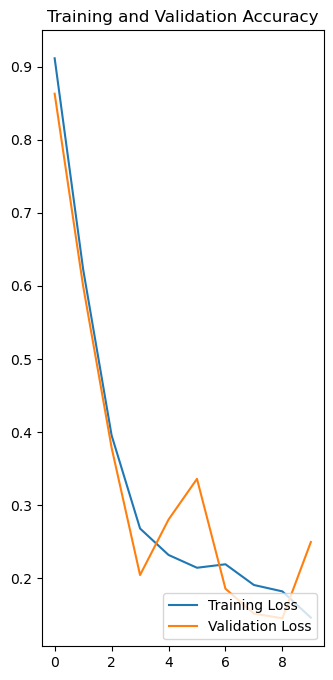

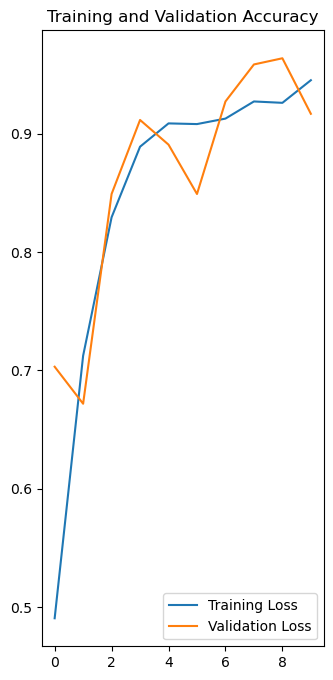

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),history_loss,label='Training Loss')
plt.plot(range(EPOCHS),history_val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),history_accuracy,label='Training Loss')
plt.plot(range(EPOCHS),history_val_accuracy, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



First Image
Actual Label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Model Prediction: Potato___Late_blight


2024-05-05 08:08:11.666028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


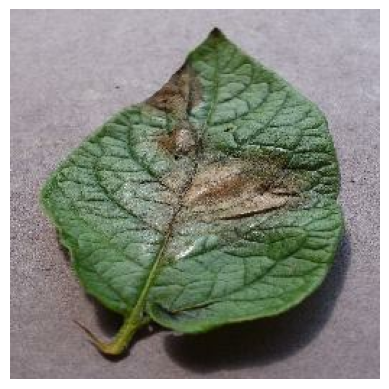

In [ ]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()

    print("First Image")
    plt.imshow(first_image)
    plt.axis('off')
    print("Actual Label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Model Prediction:", class_names[tf.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-05-05 08:08:12.287225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


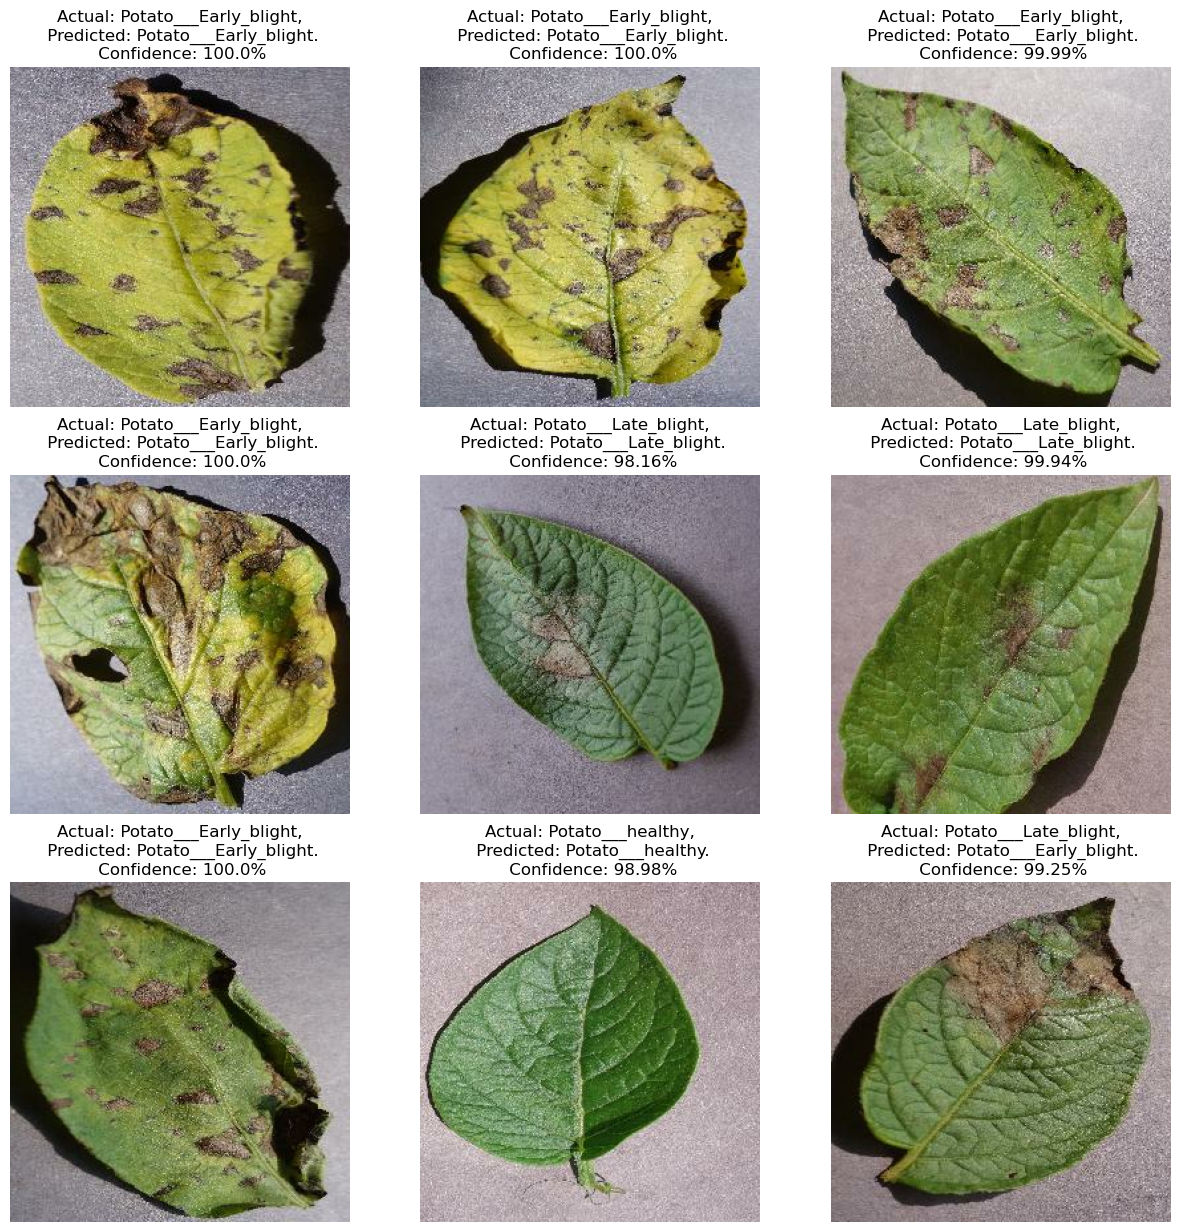

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import os
import tensorflow as tf

# Assuming `model` is your trained Keras model
model_version = 2

# Save the model with .keras extension
model_path = f"/Users/athulnambiar/Desktop/PROJECTS/POTATO DISEASE/model/model_{model_version}.keras"
model.save(model_path)